<a href="https://colab.research.google.com/github/jjzsilva9/vico/blob/main/VICO_Week_8_2024_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VICO Week 8 Practical: Binocular Stereo and 3D Reconstruction

This week you will compute a depth map from a pair of images using binocular stereo. This will combine several things you've learnt about recently:

1. Extract and match local features
2. Robustly fit a geometric model (in this case the fundamental matrix) to the matched features using RANSAC while also removing outliers
3. Rectify the images by warping using homographies estimated from the fundamental matrix
4. Compute a disparity map by searching for dense matches between rectified images using binocular stereo

As an extra challenge you can attempt to convert the disparity map into a 3D point cloud.

##0. Data and set up

Let's start by installing the correct version of OpenCV, importing packages and loading a stereo dataset. Take a look at the images. Can you see that closer objects move more between views?

In [1]:
!pip install opencv-contrib-python==4.5.5.62

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.10.0.84
    Uninstalling opencv-contrib-python-4.10.0.84:
      Successfully uninstalled opencv-contrib-python-4.10.0.84


--2024-12-24 16:42:58--  https://www-users.york.ac.uk/~waps101/VICO/imL.png
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268493 (262K) [image/png]
Saving to: ‘imL.png’

imL.png             100%[===================>] 262.20K   355KB/s    in 0.7s    

2024-12-24 16:42:59 (355 KB/s) - ‘imL.png’ saved [268493/268493]

--2024-12-24 16:42:59--  https://www-users.york.ac.uk/~waps101/VICO/imR.png
Resolving www-users.york.ac.uk (www-users.york.ac.uk)... 144.32.129.58, 2001:630:61:180::1:13a
Connecting to www-users.york.ac.uk (www-users.york.ac.uk)|144.32.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271763 (265K) [image/png]
Saving to: ‘imR.png’

imR.png             100%[===================>] 265.39K   397KB/s    in 0.7s    

2024-12-24 16:43:00 (397 KB/s) - ‘imR.png’

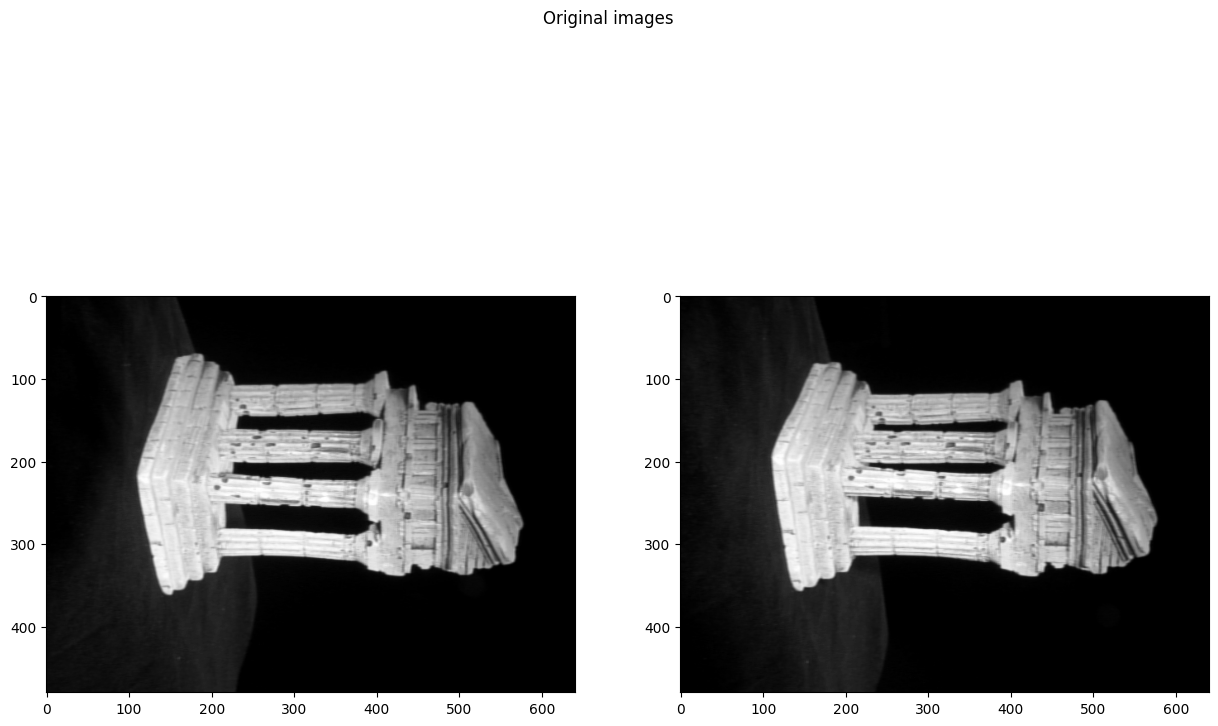

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Download images
!wget https://www-users.york.ac.uk/~waps101/VICO/imL.png
!wget https://www-users.york.ac.uk/~waps101/VICO/imR.png

# Read both images and convert to grayscale
img1 = cv2.imread('imL.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('imR.png', cv2.IMREAD_GRAYSCALE)

f = 1520.4
cx = 302.32
cy = 246.87
K1 = np.array([[f,0,cx],[0,f,cy],[0,0,1]])
K2 = np.array([[f,0,cx],[0,f,cy],[0,0,1]])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1, cmap="gray")
axes[1].imshow(img2, cmap="gray")
plt.suptitle("Original images")
plt.show()

##1. Extracting and matching local features

Reuse the code from the week 4 practical to extract and match features from the two images. You can use brute force matching followed by the Lowe ratio test to retain only distinctive matches. Visualise the matches to check they look sensible.

916


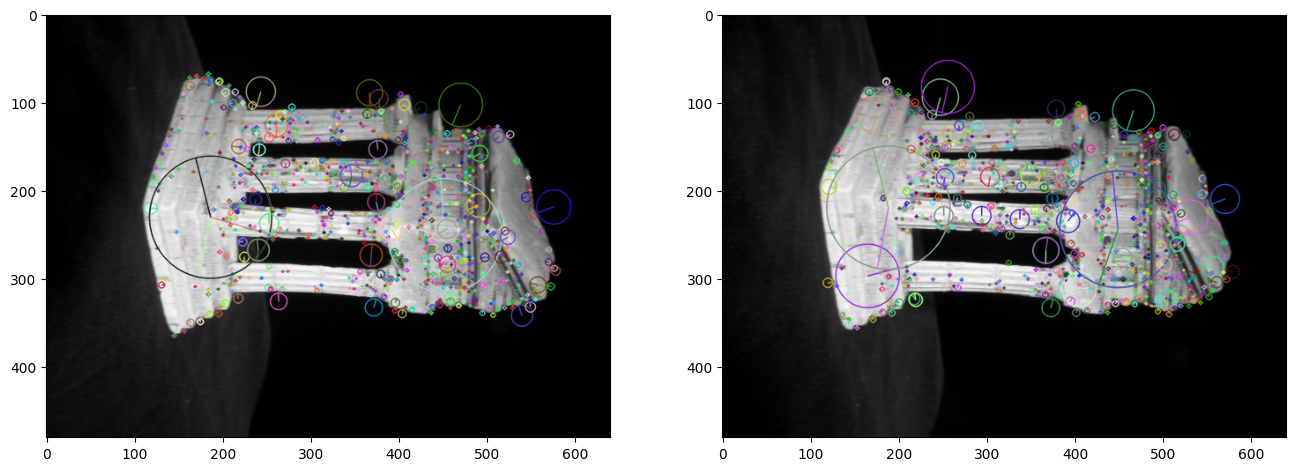

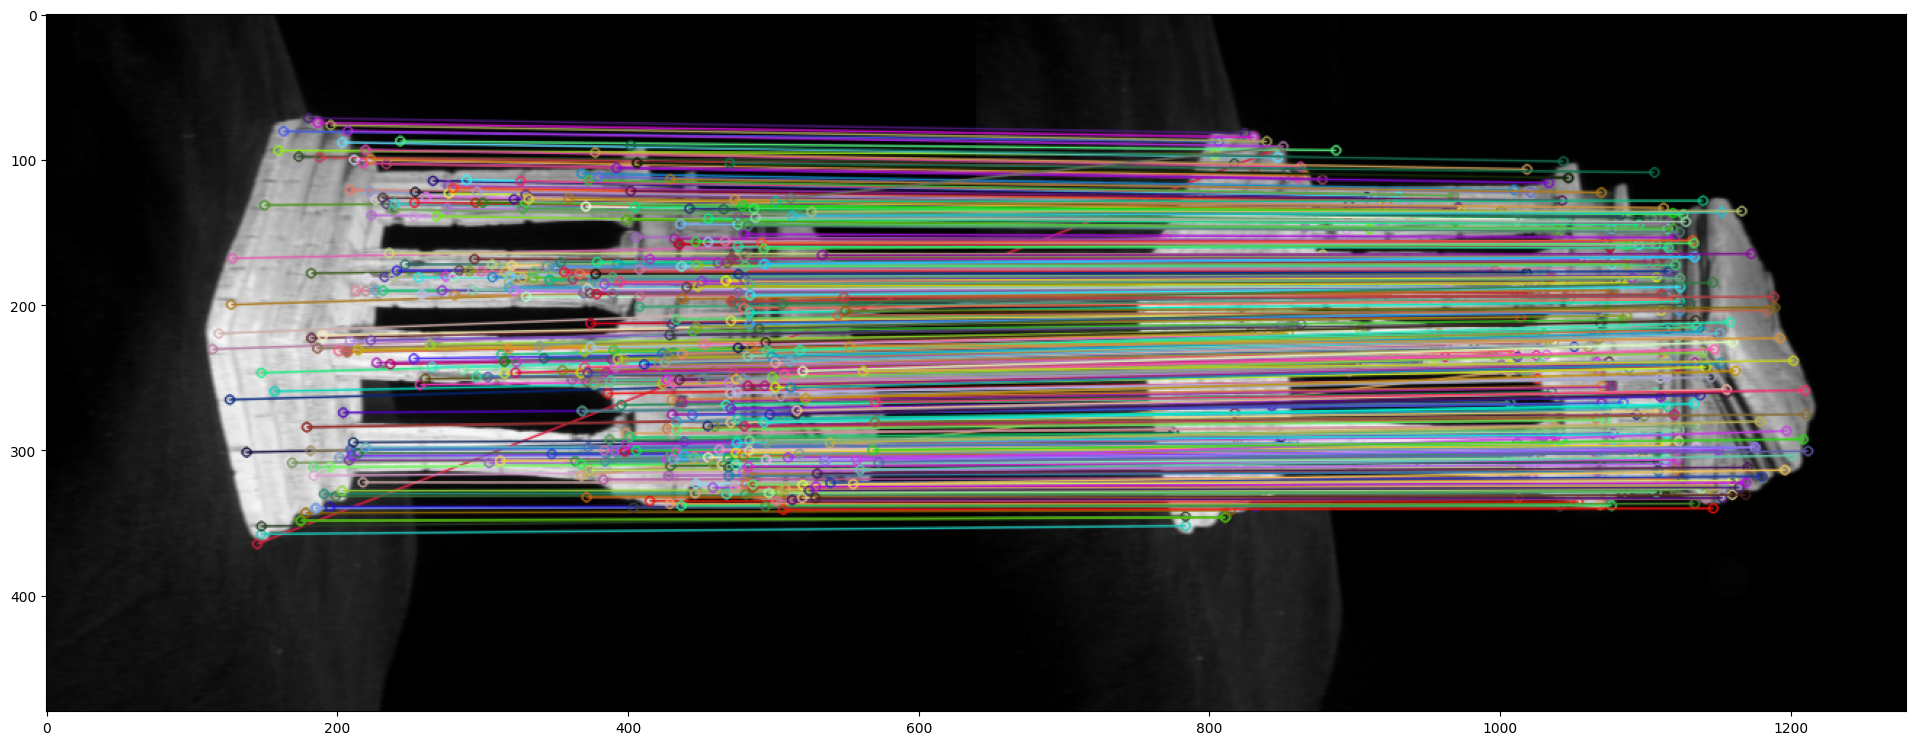

In [4]:
# Create a SIFT detector and inizialise it with the default parameters. N.B. : the parameter values might differ from the ones suggested in the 2004 paper by Lowe.
sift = cv2.SIFT_create()

# Feature detection
key_points1 = sift.detect(img1,None)
# Feature description
_, descriptors1 = sift.compute(img1, key_points1)
imgOut1 = np.copy(img1)
imgKp1 = cv2.drawKeypoints(img1,key_points1, imgOut1 ,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# We can also do feature detection and description in one step
key_points2, descriptors2 = sift.detectAndCompute(img2,None)
#_, descriptors2 = sift.compute(img2_gray, key_points2)
imgOut2 = np.copy(img2)
imgKp2 = cv2.drawKeypoints(img2,key_points2, imgOut2 ,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig=plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(imgKp1, cmap = "gray")
fig.add_subplot(1,2,2)
plt.imshow(imgKp2, cmap = "gray")

# BFMatcher with default params
bf = cv2.BFMatcher.create(cv2.NORM_L2, crossCheck = False)
n_neighbours = 2
matches = bf.knnMatch(descriptors1,descriptors2, n_neighbours)
print(len(descriptors1))


possiblyCorrectMatches = [[m] for m, n in matches if m.distance < 0.7 * n.distance]
# Your code goes here: apply the criterion definend by Lowe; th=0.7

# Draw the matches and visualise them
img_matched = cv2.drawMatchesKnn(img1, key_points1, img2, key_points2, possiblyCorrectMatches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig=plt.figure(figsize=(24,24))
plt.imshow(img_matched)
plt.show()

In [12]:
# Initialize lists to store points
pts1 = []
pts2 = []

# Iterate through good matches and extract points
for match in possiblyCorrectMatches:
    pts1.append(key_points1[match[0].queryIdx].pt)
    pts2.append(key_points2[match[0].trainIdx].pt)

# Convert to NumPy arrays for easier handling
pts1 = np.array(pts1)
pts2 = np.array(pts2)

##2. Fit a fundamental matrix using RANSAC

Next we want to filter the matches so that they are consistent with 2 view geometry. Unlike in Topic 2, you don't need to implement this from scratch. There is a built in function `cv2.findFundamentalMat` that will do this for you. Look it up and find the right way to call it to use RANSAC. Remove outliers from your matched points. As an extension, try converting the fundamental matrix to an essential matrix and then decomposing it to the relative pose between the two images.

In [13]:
F, inliers = cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]
print(F)

[[-9.76843488e-06 -4.55837522e-05 -2.24857379e-01]
 [ 6.60818472e-05  2.50281721e-07 -4.05041745e-02]
 [ 2.28522195e-01  2.86993355e-02  1.00000000e+00]]


##3. Rectify the images

Before we can apply binocular stereo algorithms, we need to rectify the images so that the matching pixel for any given pixel will lie on the same horiztonal row of pixels (this simplifies correspondence matching into a 1D search). The warp required for rectification is like adjusting the image planes of the two cameras so that they are parallel. As you know, you can warp a plane to another plane using a homography. The required homographies can be found with the function `cv2.stereoRectifyUncalibrated`. Find the right way to call this and apply the homographies using `cv2.warpPerspective`. Then visualise the rectified images. If you draw some lines across the images you should see that any point on a line in the first image lies on the same line in the second image.

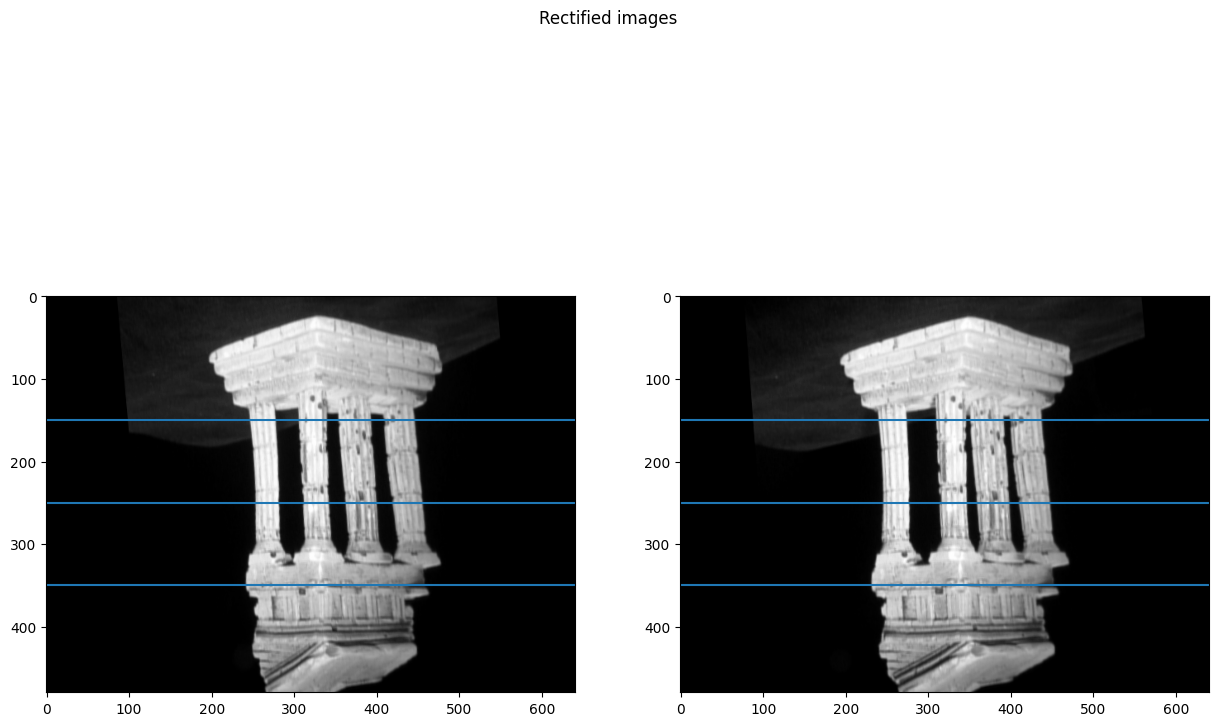

In [18]:
h1, w1 = img1.shape
h2, w2 = img2.shape

a, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, (w1, h1))

img1_rectified = cv2.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img2, H2, (w1, h1))

# Draw the rectified images
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(img1_rectified, cmap="gray")
axes[1].imshow(img2_rectified, cmap="gray")
axes[0].axhline(150)
axes[1].axhline(150)
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(350)
axes[1].axhline(350)
plt.suptitle("Rectified images")
plt.show()

##4. Apply binocular stereo

You're now ready to apply binocular stereo to the rectified images. OpenCV has a few algorithms for this. Try using the basic block matching algorithm `cv2.StereoBM_create` or `cv2.StereoSGBM_create`. You might need to play with the parameters a little. Then visualise the *disparity map* that is outputted. If the disparity map is called $d(x,y)$ then it tells you that it believes pixel $(x,y)$ in the left image corresponds to pixel $(x+d(x,y),y)$ in the second.

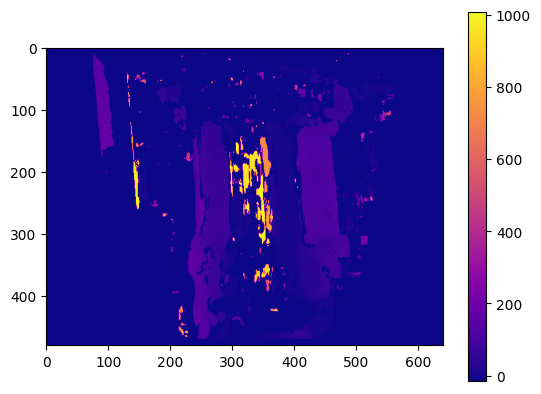

In [19]:
stereo = cv2.StereoBM_create(numDisparities=64, blockSize=21)
disparity = stereo.compute(img1_rectified, img2_rectified)

plt.imshow(disparity, cmap='plasma')
plt.colorbar()
plt.show()

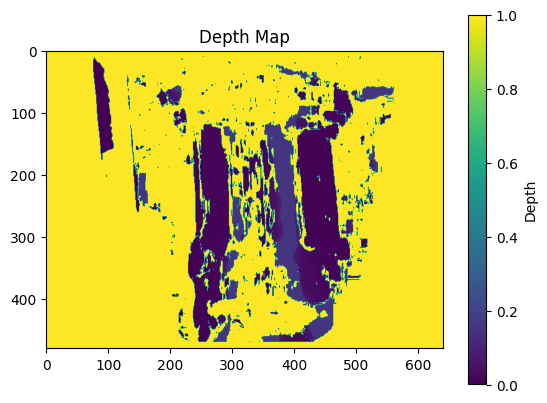

In [41]:

baseline = 0.1 #meters
focal_length_pixel = 3

disparity = cv2.normalize(disparity, None, 0.01, 10000)
depth_map = (1000 / disparity)**2
# Normalize depth map for better visualization
depth_map_normalized = cv2.normalize(depth_map, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)


plt.imshow(depth_map_normalized)
plt.colorbar(label='Depth')  # Add colorbar with a label
plt.title('Depth Map')
plt.show()

##5. Challenge: compute a 3D point cloud

The disparity map gives you correspondence. From correspondence, you can triangulate 3D position (see Week 3, video lecture 3). As a final challenge, can you convert your disparity map into a 3D point cloud and plot it in 3D? Alternatively, you could use the sparse matches from RANSAC that you computed above.

The additional information you need is that the pose of the first camera $[\mathbf{R}_1 \mathbf{t}_1]$ is:


In [ ]:
Rt1 = np.array([[0.11541167827420966000,0.99138900083137627000,0.06187078105613172400,-0.0193474918165],
                [-0.68405289691836879000,0.03416081723372646500,0.72863205583031487000,0.04321050765],
                [0.72024424935956100000,-0.12641553542381334000,0.68210507523987296000,0.589790751867]])

and the second camera $[\mathbf{R}_2 \mathbf{t}_2]$ is:


In [ ]:
Rt2 = np.array([[0.12777196254899612000,0.99067700959105598000,0.04725873733079036200,-0.020311130356],
                [-0.58073706790091917000,0.03610343749372974000,0.81329023095508723000,0.0452044463785],
                [0.80400173106295025000,-0.13136058948124074000,0.57993586885009962000,0.583107596409]])

There are various functions built into OpenCV that might be helpful or you can code it from scratch using the linear least squares method shown in the video lecture. You might want to ignore disparities that are very large. The plotting itself can be done with matplotlib `scatter3D`.